# Making predictions on Protegrin-1 mutants 

Here is the procedure used to predicty activity, selectivity and hemolysis in all possible single, double, and triple mutants of protegrin-1. 

In [29]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

import joblib
from sklearn.decomposition import PCA
from sklearn import metrics

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [30]:
# load PCA weights and models for activity prediction
pca_mic = joblib.load('models/pca30_weights_v03_mic.pkl') # mic
model_mic = joblib.load('models/model_v03_GNB30_esm2_15B_activity_classification.pkl')

# load PCA weights and models for selectivity prediction
pca_sel = joblib.load('models/pca15_weights_v03_sel.pkl') # sel
model_sel = joblib.load('models/model_v03_SVR15_esm2_15B_selectivity_regression.pkl')

# load PCA weights and models for hemolysis prediction
pca_hemo = joblib.load('models/pca25_weights_v03_hemo.pkl') # hemo
model_hemo = joblib.load('models/model_v03_Lasso25_esm2_15B_hemolysis_regression.pkl')


## Predictions on single mutation Protegrin-1 Variants

In [31]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_1mut.csv', index_col=0)
meta_data

,ID,Sequence
0,1mut_0,RGGRLCYCRRRFCVLVGR
1,1mut_1,RMGRLCYCRRRFCVCVGR
2,1mut_2,RGGRLCYCRRRFCVCVFR
3,1mut_3,EGGRLCYCRRRFCVCVGR
4,1mut_4,RGGNLCYCRRRFCVCVGR
...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR
339,1mut_339,RGGRLCYCRRKFCVCVGR
340,1mut_340,RGGRLCHCRRRFCVCVGR
341,1mut_341,RGGRLCYCRRDFCVCVGR


In [32]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = 'data/embedding/esm2_15B_pg1_1mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


## merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
# df

In [33]:
# load embeddings from a pickle file
df = pd.read_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,1mut_0,RGGRLCYCRRRFCVLVGR,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,1mut_1,RMGRLCYCRRRFCVCVGR,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,1mut_3,EGGRLCYCRRRFCVCVGR,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077

## Predicting active variants with AMP MBC <= 8

In [34]:
features = df.iloc[:,2:]
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,-0.175508,0.016926,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,-0.090511,0.077786,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,-0.093007,-0.003598,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,-0.118641,0.097144,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077252,-0.082461,0.261394,0.016504,0

### Prediction Activity 

In [35]:
# creates a df to save probabilities
res_mic = df.iloc[:,0:1].copy()

# calculates the probability of being active
X = pca_mic.transform(features)
prob= model_mic.predict_proba(X)
prob= [(x[1]*100).round(2) for x in prob]

res_mic['MIC_8_prob']= prob

#number of peptides with probability == 100%
print(f"{res_mic.query('MIC_8_prob > 90').shape[0]} peptides with probability == 90% to be active")

148 peptides with probability == 90% to be active


### Predicting selectivity score

In [36]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
X = pca_sel.transform(features)
prob= model_sel.predict(X)
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.8
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

0 peptides with selectivity score < 0.5


### Prediction of Hemolysis % to protegrin-1 variants

In [37]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
X = pca_hemo.transform(features)
pred= model_hemo.predict(X)
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

0 peptides with predicted hemolysis% < 2%


## Results of single mutant

In [38]:
results = res_mic.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,95.58,1.69,8.940000
1,1mut_1,RMGRLCYCRRRFCVCVGR,98.03,2.52,32.990002
2,1mut_2,RGGRLCYCRRRFCVCVFR,83.15,2.82,38.150002
3,1mut_3,EGGRLCYCRRRFCVCVGR,96.38,2.39,26.790001
4,1mut_4,RGGNLCYCRRRFCVCVGR,96.94,2.30,27.219999
...,...,...,...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR,73.31,2.36,19.020000
339,1mut_339,RGGRLCYCRRKFCVCVGR,41.84,2.50,29.129999
340,1mut_340,RGGRLCHCRRRFCVCVGR,88.23,2.02,17.920000
341,1mut_341,RGGRLCYCRRDFCVCVGR,82.17,2.42,25.799999


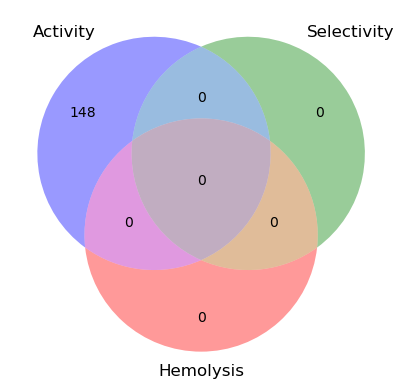

In [39]:
# Define the sets as lists of elements
set1 = set(results.query('MIC_8_prob > 90')['ID'].values)
set2 = set(results.query('selectivity_pred < 1')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MIC_HEMO_SEL_1mut_venn3_predictions_v01.png')
plt.show()

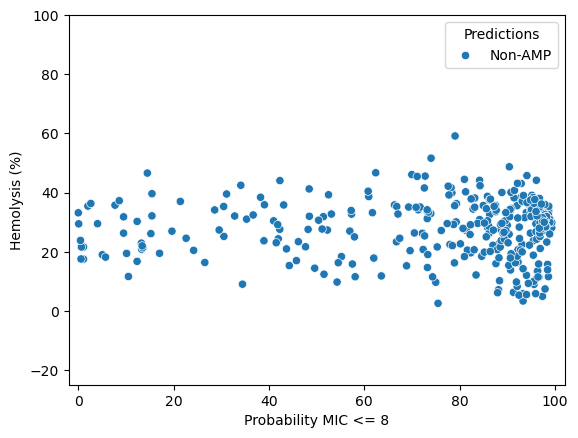

In [40]:
color1 = results.apply(lambda x: 'AMP' if x['MIC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MIC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MIC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

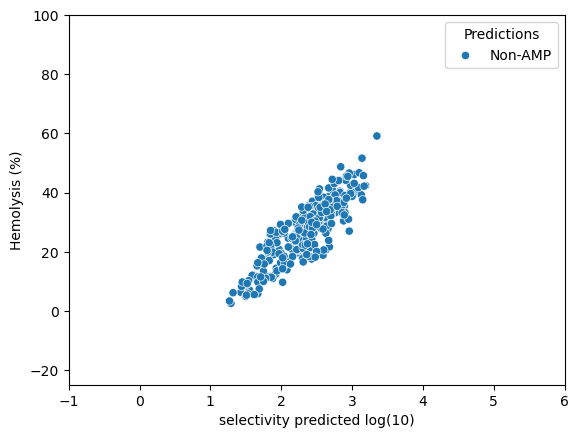

In [41]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 0.5 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

In [42]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1mut_v03.csv')

## Predictions on double mutation Protegrin-1 Variants

In [43]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_2mut.csv', index_col=0)
meta_data

,ID,Sequence
0,2mut_0,RGPRLCYCRRRQCVCVGR
1,2mut_1,YGGPLCYCRRRFCVCVGR
2,2mut_2,RKGRLCGCRRRFCVCVGR
3,2mut_3,RGGRLCYCRRWFCVKVGR
4,2mut_4,RGGRLCYCMRRFCVCDGR
...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR
55572,2mut_55572,RGGRLCYCRRRHDVCVGR
55573,2mut_55573,RGGRMCYCRRRFCVCVAR
55574,2mut_55574,RGGRLCYCRIRFIVCVGR


In [44]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = '/stor/work/Wilke/luiz/ML_PG1/embeddings/esm2_15B_pg1_2mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# # merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_2mut.pkl')

In [45]:
# load embeddings from a pickle file
df = pd.read_pickle(f'data/embedding/esm2_15B_pg1_2mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,2mut_0,RGPRLCYCRRRQCVCVGR,0.030471,-0.036276,-0.111070,0.150194,-0.230985,0.181216,-0.178246,0.158280,-0.044290,0.140545,-0.173849,-0.074231,0.127456,0.139890,0.141800,-0.161217,0.052185,-0.073374,0.231049,0.004841,0.076786,-0.000564,-0.235507,0.093585,-0.094216,-0.030184,0.090808,-0.017730,0.056953,0.168276,-0.138922,-0.055812,-0.238720,-0.121912,-0.131041,0.009613,0.166661,-0.117495,0.190636,-0.058775,0.083950,-0.137385,0.066807,0.088748,-0.054584,0.269736,0.049476,0.108028,...,-0.332250,-0.182212,0.188159,-0.089034,-0.064079,0.156366,-0.090362,-0.010652,0.187834,0.213740,-0.055363,-0.009788,0.014521,0.185780,0.124452,0.013869,-0.185609,0.156731,-0.108033,-0.137903,-0.097508,-0.199132,-0.055758,-0.013001,0.282426,-0.031745,0.175234,-0.038487,0.071631,0.056087,0.094258,0.134074,-0.014872,-0.083226,-0.015783,0.033664,-0.126464,-0.285006,-0.048229,0.061758,-0.191082,-0.151428,0.059017,-0.244604,0.117419,-0.155859,-0.045599,-0.075758,-0.259623,0.045590
1,2mut_1,YGGPLCYCRRRFCVCVGR,0.078283,-0.004239,-0.083609,0.105327,-0.233435,0.161460,-0.106038,0.203431,-0.081741,0.155934,-0.148036,-0.138177,0.127338,0.172699,0.143295,-0.190010,0.101302,-0.077433,0.149300,0.018422,0.155382,0.059158,-0.202118,0.056027,-0.144371,-0.061357,0.085607,-0.040719,0.005678,0.153111,-0.134872,-0.038001,-0.213945,-0.130888,-0.058073,0.013071,0.204674,-0.049626,0.176748,-0.075964,0.177314,-0.164634,0.122157,0.013722,-0.078917,0.326256,0.102039,0.064966,...,-0.208491,-0.181908,0.204974,0.013904,-0.081345,0.084125,-0.008529,-0.013594,0.245070,0.272875,-0.054534,0.077179,0.028892,0.122911,0.150612,-0.056876,-0.118520,0.162811,-0.106010,-0.062028,-0.084144,-0.140908,-0.094160,-0.074398,0.280061,-0.020089,0.090262,0.008972,-0.009543,0.066797,0.110991,0.168301,-0.014092,-0.092231,0.006551,0.018966,-0.110038,-0.285004,-0.044679,0.036731,-0.182719,-0.162484,0.037435,-0.229143,0.173071,-0.190800,-0.026766,-0.103359,-0.266636,0.025352
2,2mut_2,RKGRLCGCRRRFCVCVGR,0.085428,-0.057224,-0.048115,0.131888,-0.233556,0.146629,-0.058954,0.145036,-0.012269,0.208369,-0.116377,-0.063401,0.179298,0.176179,0.089100,-0.128998,0.192588,-0.062569,0.056391,-0.061444,0.136877,0.051762,-0.240653,0.131735,-0.155009,-0.012141,0.110780,-0.081294,0.068365,0.167697,-0.143250,0.005252,-0.351505,-0.103353,-0.154235,0.003228,0.185293,-0.056369,0.242288,-0.047226,0.159304,-0.101366,0.098639,0.058434,-0.045043,0.278100,0.043613,0.063437,...,-0.328105,-0.162223,0.256969,-0.061340,-0.029240,0.072979,-0.043325,-0.013580,0.229346,0.264277,-0.033285,0.013914,-0.017617,0.160241,0.176237,-0.087623,-0.177227,0.208036,-0.145973,0.000206,-0.188131,-0.057958,-0.108080,-0.064826,0.241150,0.070687,0.167148,-0.012571,-0.008496,0.036840,0.092076,0.183831,-0.038787,-0.071339,-0.011860,-0.058060,-0.045512,-0.228114,-0.049612,-0.007920,-0.166855,-0.198541,0.027955,-0.190623,0.077585,-0.172339,0.024809,-0.092293,-0.187360,0.020935
3,2mut_3,RGGRLCYCRRWFCVKVGR,0.057880,-0.050223,-0.124206,0.076189,-0.272554,0.140542,-0.079627,0.214544,-0.021029,0.190860,-0.159807,-0.098083,0.199157,0.179230,0.109095,-0.135120,0.113276,-0.068056,0.066501,0.022015,0.165217,0.009979,-0.291171,0.147817,-0.147829,-0.041164,0.068331,-0.102698,-0.041732,0.109131,-0.132808,-0.042759,-0.286052,-0.113242,-0.090135,-0.022518,0.168574,-0.058750,0.236315,-0.028953,0.159713,-0.287824,0.157747,0.060543,-0.057961,0.306598,0.056881,0.039657,...,-0.307967,-0.126027,0.237130,-0.060796,-0.106810,0.076391,-0.032235,0.007105,0.312369,0.172563,-0.045592,0.099534,0.065470,0.134455,0.143874,0.002906,-0.142259,0.190600,-0.021462,-0.018197,-0.208055,-0.071023,-0.0

### Prediction of active variants (MBC <= 8)

In [46]:
features = df.iloc[:,2:]
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.030471,-0.036276,-0.111070,0.150194,-0.230985,0.181216,-0.178246,0.158280,-0.044290,0.140545,-0.173849,-0.074231,0.127456,0.139890,0.141800,-0.161217,0.052185,-0.073374,0.231049,0.004841,0.076786,-0.000564,-0.235507,0.093585,-0.094216,-0.030184,0.090808,-0.017730,0.056953,0.168276,-0.138922,-0.055812,-0.238720,-0.121912,-0.131041,0.009613,0.166661,-0.117495,0.190636,-0.058775,0.083950,-0.137385,0.066807,0.088748,-0.054584,0.269736,0.049476,0.108028,-0.137416,-0.012448,...,-0.332250,-0.182212,0.188159,-0.089034,-0.064079,0.156366,-0.090362,-0.010652,0.187834,0.213740,-0.055363,-0.009788,0.014521,0.185780,0.124452,0.013869,-0.185609,0.156731,-0.108033,-0.137903,-0.097508,-0.199132,-0.055758,-0.013001,0.282426,-0.031745,0.175234,-0.038487,0.071631,0.056087,0.094258,0.134074,-0.014872,-0.083226,-0.015783,0.033664,-0.126464,-0.285006,-0.048229,0.061758,-0.191082,-0.151428,0.059017,-0.244604,0.117419,-0.155859,-0.045599,-0.075758,-0.259623,0.045590
1,0.078283,-0.004239,-0.083609,0.105327,-0.233435,0.161460,-0.106038,0.203431,-0.081741,0.155934,-0.148036,-0.138177,0.127338,0.172699,0.143295,-0.190010,0.101302,-0.077433,0.149300,0.018422,0.155382,0.059158,-0.202118,0.056027,-0.144371,-0.061357,0.085607,-0.040719,0.005678,0.153111,-0.134872,-0.038001,-0.213945,-0.130888,-0.058073,0.013071,0.204674,-0.049626,0.176748,-0.075964,0.177314,-0.164634,0.122157,0.013722,-0.078917,0.326256,0.102039,0.064966,-0.110125,0.141647,...,-0.208491,-0.181908,0.204974,0.013904,-0.081345,0.084125,-0.008529,-0.013594,0.245070,0.272875,-0.054534,0.077179,0.028892,0.122911,0.150612,-0.056876,-0.118520,0.162811,-0.106010,-0.062028,-0.084144,-0.140908,-0.094160,-0.074398,0.280061,-0.020089,0.090262,0.008972,-0.009543,0.066797,0.110991,0.168301,-0.014092,-0.092231,0.006551,0.018966,-0.110038,-0.285004,-0.044679,0.036731,-0.182719,-0.162484,0.037435,-0.229143,0.173071,-0.190800,-0.026766,-0.103359,-0.266636,0.025352
2,0.085428,-0.057224,-0.048115,0.131888,-0.233556,0.146629,-0.058954,0.145036,-0.012269,0.208369,-0.116377,-0.063401,0.179298,0.176179,0.089100,-0.128998,0.192588,-0.062569,0.056391,-0.061444,0.136877,0.051762,-0.240653,0.131735,-0.155009,-0.012141,0.110780,-0.081294,0.068365,0.167697,-0.143250,0.005252,-0.351505,-0.103353,-0.154235,0.003228,0.185293,-0.056369,0.242288,-0.047226,0.159304,-0.101366,0.098639,0.058434,-0.045043,0.278100,0.043613,0.063437,-0.112073,0.060039,...,-0.328105,-0.162223,0.256969,-0.061340,-0.029240,0.072979,-0.043325,-0.013580,0.229346,0.264277,-0.033285,0.013914,-0.017617,0.160241,0.176237,-0.087623,-0.177227,0.208036,-0.145973,0.000206,-0.188131,-0.057958,-0.108080,-0.064826,0.241150,0.070687,0.167148,-0.012571,-0.008496,0.036840,0.092076,0.183831,-0.038787,-0.071339,-0.011860,-0.058060,-0.045512,-0.228114,-0.049612,-0.007920,-0.166855,-0.198541,0.027955,-0.190623,0.077585,-0.172339,0.024809,-0.092293,-0.187360,0.020935
3,0.057880,-0.050223,-0.124206,0.076189,-0.272554,0.140542,-0.079627,0.214544,-0.021029,0.190860,-0.159807,-0.098083,0.199157,0.179230,0.109095,-0.135120,0.113276,-0.068056,0.066501,0.022015,0.165217,0.009979,-0.291171,0.147817,-0.147829,-0.041164,0.068331,-0.102698,-0.041732,0.109131,-0.132808,-0.042759,-0.286052,-0.113242,-0.090135,-0.022518,0.168574,-0.058750,0.236315,-0.028953,0.159713,-0.287824,0.157747,0.060543,-0.057961,0.306598,0.056881,0.039657,-0.070077,-0.037522,...,-0.307967,-0.126027,0.237130,-0.060796,-0.106810,0.076391,-0.032235,0.007105,0.312369,0.172563,-0.045592,0.099534,0.065470,0.134455,0.143874,0.002906,-0.142259,0.190600,-0.021462,-0.018197,-0.208055,-0.071023,-0.081870,-0.171144,0.213066,-0.0094

In [47]:
# creates a df to save probabilities
res_mic = df.iloc[:,0:1].copy()

# calculates the probability of being active
X = pca_mic.transform(features)
prob= model_mic.predict_proba(X)
prob= [(x[1]*100).round(2) for x in prob]

res_mic['MIC_8_prob']= prob

#number of peptides with probability == 100%
print(f"{res_mic.query('MIC_8_prob > 90').shape[0]} peptides with probability == 90% to be active")

7174 peptides with probability == 90% to be active


### Predicting selectivity score

In [48]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
X = pca_sel.transform(features)
prob= model_sel.predict(X)
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.8
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

0 peptides with selectivity score < 0.5


### Prediction nom Hemolitic variants (hemolysis% < 2%)

In [49]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
X = pca_hemo.transform(features)
pred= model_hemo.predict(X)
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

969 peptides with predicted hemolysis% < 2%


### Results of double mutants

In [50]:
results = res_mic.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,2mut_0,RGPRLCYCRRRQCVCVGR,83.58,2.05,25.540001
1,2mut_1,YGGPLCYCRRRFCVCVGR,95.97,2.59,29.870001
2,2mut_2,RKGRLCGCRRRFCVCVGR,17.07,2.05,15.040000
3,2mut_3,RGGRLCYCRRWFCVKVGR,5.40,2.09,22.299999
4,2mut_4,RGGRLCYCMRRFCVCDGR,4.90,2.20,20.400000
...,...,...,...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR,40.07,2.80,36.680000
55572,2mut_55572,RGGRLCYCRRRHDVCVGR,3.24,1.05,1.180000
55573,2mut_55573,RGGRMCYCRRRFCVCVAR,96.48,2.24,28.820000
55574,2mut_55574,RGGRLCYCRIRFIVCVGR,60.22,2.66,18.350000


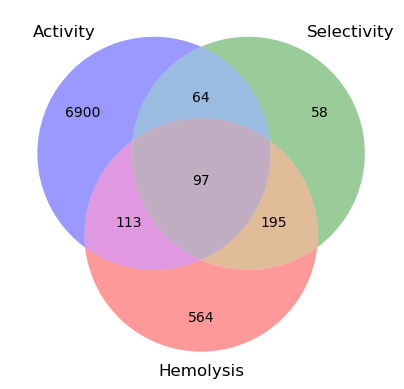

In [51]:
# Define the sets as lists of elements
set1 = set(results.query('MIC_8_prob > 90')['ID'].values)
set2 = set(results.query('selectivity_pred < 1')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MIC_HEMO_SEL_2mut_venn3_predictions_v02.png')
plt.show()

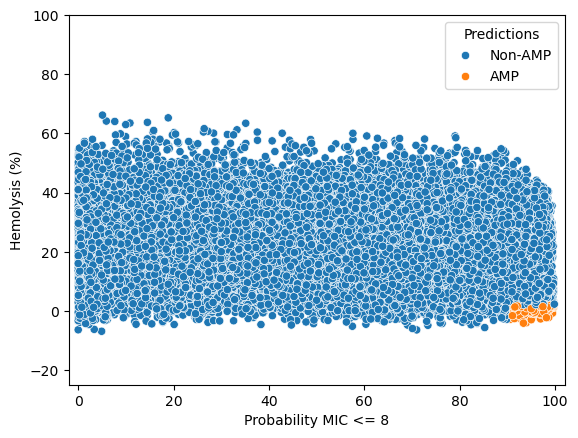

In [52]:
color1 = results.apply(lambda x: 'AMP' if x['MIC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MIC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MIC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

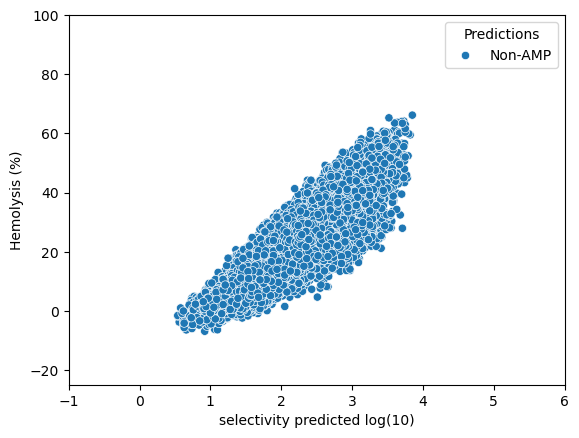

In [53]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 0.5 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

In [54]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_2mut_v03.csv')

## Predictions on triple mutant Protegrin-1 Variants

In [57]:
### Those functions will be used to predict the triple mutants in a loop
def run_mic(features):    
    # creates a df to save probabilities
    res_mic = pd.DataFrame()

    # calculates the probability of being active
    X = pca_mic.transform(features)
    prob= model_mic.predict_proba(X)
    prob= [(x[1]*100).round(2) for x in prob]
    
    res_mic['ID']=features.index
    res_mic['MIC_8_prob']=prob

    return res_mic

In [58]:
### Predicting selectivity score
def run_sel(features):
    # creates a df to selectivity score
    res_sel = pd.DataFrame()

    # calculates the the selectivity score
    X = pca_sel.transform(features)
    prob= model_sel.predict(X)

    res_sel['ID']=features.index
    res_sel['selectivity_pred']= prob.round(2) 

    return res_sel

In [59]:
### Prediction nom Hemolitic variants (hemolysis% < 2%)
def run_hemo(features):
    # creates a df to save hemolysis score
    res_hemo = pd.DataFrame()

    # calculates the the hemolysis score
    X = pca_hemo.transform(features)
    pred= model_hemo.predict(X)

    res_hemo['ID']=features.index
    res_hemo['hemolysis_pred']= pred.round(2)

    return res_hemo

### Preprocess the embedding from a tensor file to a lighter pickle file

In [30]:
# import multiprocessing

# # this was required to load the embeddings with multiple CPUs due the large file sizes
# for i in range(1,7):
#     '''this loop will load the embeddings with multiple CPUs and save them in a pickle file'''

#     # Set the directory containing the Torch files
#     data_dir = f'data/embedding/esm2_15B_pg1_3mut/esm2_15B_pg1_3mut_{i}mil/'

#     # Define the function to load a Torch file
#     def load_torch_file(filename):
#         filepath = os.path.join(data_dir, filename)
#         label = filename.split('.pt')[0]
#         embeddings = {}
#         embeddings[label] = np.array(torch.load(filepath)['mean_representations'][48])
#         return embeddings

#     # Get a list of all the Torch files in the directory
#     file_list = os.listdir(data_dir)

#     # Define the number of processes to use
#     num_processes = 50

#     # Create a multiprocessing pool with the number of processes defined above
#     pool = multiprocessing.Pool(processes=num_processes)

#     # Use the pool to load all the Torch files in parallel
#     results = pool.map(load_torch_file, file_list)

#     # Close the pool
#     pool.close()

#     # Concatenate the results into a single list
#     all_data = {k: v for d in results for k, v in d.items()}

#     # Convert the dictionary to a NumPy array
#     arr = np.array(list(all_data.values()))

#     # Set the keys as the index
#     index = list(all_data.keys())

#     # Create a DataFrame from the array
#     df = pd.DataFrame(arr, index=index)

#     # Print the DataFrame and renamed it
#     df.to_pickle(f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl')

### Loaning the pre processced embedding from a pickle file and run prediction on each splited file
I have to split the files in 6 parts due its huge size

In [60]:
# read the CSV files and concatenate them row-wise
predictions = pd.DataFrame()

for i in range(1, 7):
    file_path = f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl'
    features = pd.read_pickle(file_path)
    print(f'Processing file esm2_15B_pg1_3mut_{i}mil, size: {features.shape}')
    
    res_mic = run_mic(features)
    res_sel = run_sel(features)
    res_hemo = run_hemo(features)
    
    res = res_mic.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
    res = res.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')

    predictions = pd.concat([predictions, res], axis=0).reset_index(drop=True)
    print(f'Prediction size: {predictions.shape[0]}')

predictions

Processing file esm2_15B_pg1_3mut_1mil, size: (1000000, 5120)
Prediction size: 1000000
Processing file esm2_15B_pg1_3mut_2mil, size: (1000000, 5120)
Prediction size: 2000000
Processing file esm2_15B_pg1_3mut_3mil, size: (1000000, 5120)
Prediction size: 3000000
Processing file esm2_15B_pg1_3mut_4mil, size: (1000000, 5120)
Prediction size: 4000000
Processing file esm2_15B_pg1_3mut_5mil, size: (1000000, 5120)
Prediction size: 5000000
Processing file esm2_15B_pg1_3mut_6mil, size: (652520, 5120)
Prediction size: 5652520


,ID,MIC_8_prob,selectivity_pred,hemolysis_pred
0,PG1_3mut_602975,47.51,2.07,12.970000
1,PG1_3mut_185031,34.39,2.25,10.300000
2,PG1_3mut_332050,4.00,1.36,4.400000
3,PG1_3mut_938612,34.07,2.97,31.450001
4,PG1_3mut_894404,1.82,1.96,17.690001
...,...,...,...,...
5652515,PG1_3mut_5154857,52.84,1.91,14.750000
5652516,PG1_3mut_5261581,45.61,1.99,16.629999
5652517,PG1_3mut_5406149,58.46,2.65,17.969999
5652518,PG1_3mut_5061684,74.62,2.03,18.459999


## Load meta data and merge with results

In [61]:
meta_data = pd.read_csv('data/protegrin_variants_3mut.csv', index_col=0)
results = meta_data.merge(predictions, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,PG1_3mut_0,HGGRLCYCRRRFCVCQTR,1.08,1.78,17.830000
1,PG1_3mut_1,RGGQLCYVRRRFCVAVGR,94.84,1.37,6.070000
2,PG1_3mut_2,RCYRLCRCRRRFCVCVGR,3.15,2.60,34.290001
3,PG1_3mut_3,RGSRLCYCRRRFCMCVIR,21.10,2.43,34.610001
4,PG1_3mut_4,RGGRRCYCWRAFCVCVGR,89.97,2.80,40.990002
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,25.12,2.22,17.740000
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,2.86,15.900000
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.08,2.96,17.490000
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,8.45,1.49,6.820000


In [62]:
# saving results
results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_3mut_v03.csv')

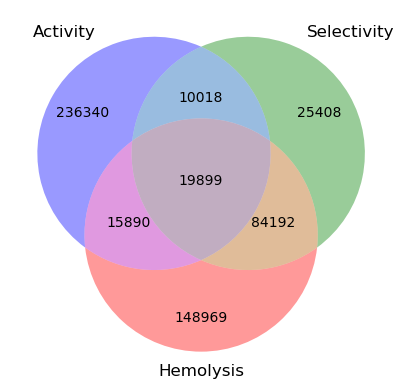

In [63]:
# Define the sets as lists of elements
set1 = set(results.query('MIC_8_prob > 90')['ID'].values)
set2 = set(results.query('selectivity_pred < 1')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
plt.show()

In [ ]:
color1 = results.apply(lambda x: 'AMP' if x['MIC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MIC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MIC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

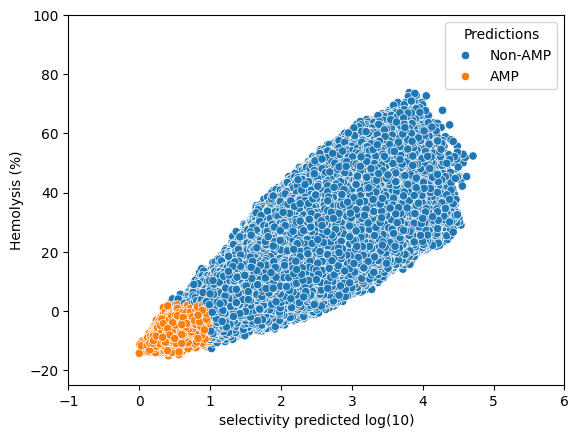

In [36]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 1 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

# Merge predictions and visualization

In [131]:
# loop trhrough the 3 predictions files and concatenate them
files = []
for i in range(1, 4):
    file = pd.read_csv(f'results/predictions_MIC_SEL_HEMO_models_PG1_{i}mut_v03.csv', index_col=0)
    files.append(file)

data = pd.concat(files, axis=0)
data

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,95.58,1.69,8.94
1,1mut_1,RMGRLCYCRRRFCVCVGR,98.03,2.52,32.99
2,1mut_2,RGGRLCYCRRRFCVCVFR,83.15,2.82,38.15
3,1mut_3,EGGRLCYCRRRFCVCVGR,96.38,2.39,26.79
4,1mut_4,RGGNLCYCRRRFCVCVGR,96.94,2.30,27.22
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,25.12,2.22,17.74
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,2.86,15.90
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.08,2.96,17.49
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,8.45,1.49,6.82


In [140]:
## SAVE the file compressed
#data.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_v03.csv.gz', index=False, compression='gzip')
data.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_v03.csv.gz', index=False)

## LOAD the file
#data = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_v03.csv.gz', compression='gzip')

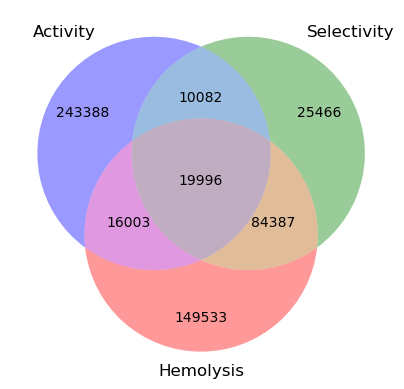

In [132]:
#Define the sets as lists of elements
set1 = set(data.query('MIC_8_prob > 90')['ID'].values)
set2 = set(data.query('selectivity_pred < 1')['ID'].values)
set3 = set(data.query('hemolysis_pred <= 2')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
plt.savefig('results/MIC_HEMO_SEL_all_mutations_venn3_predictions_most_active_v03.png')
plt.show()

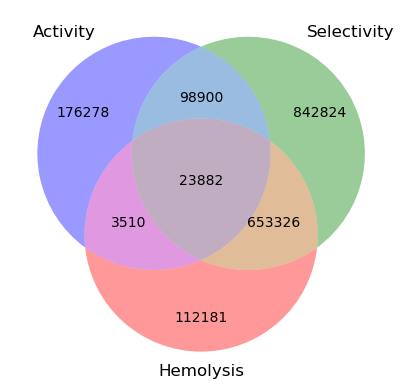

In [133]:
#Define the sets as lists of elements
set1 = set(data.query('MIC_8_prob ==0')['ID'].values)
set2 = set(data.query('selectivity_pred > 2.5')['ID'].values)
set3 = set(data.query('hemolysis_pred > 30')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('results/MIC_HEMO_SEL_all_mutations_venn3_predictions_least_active_v03.png')

plt.show()

In [134]:
### Most active
most_act = data.query('MIC_8_prob > 90 and selectivity_pred < 1 and hemolysis_pred <=2').copy()

### Least active
least_act = data.query('MIC_8_prob ==0 and selectivity_pred > 2.5 and hemolysis_pred > 30').copy()

print(f"Number of peptides: {most_act.shape[0]}")
print(f"Number of peptides: {least_act.shape[0]}")

Number of peptides: 19996
Number of peptides: 23882


### AA frequency change in most active peptides

In [135]:
# def to find the differences between the residues
idx = "RRRRICYCPLRFYVCVGR"

def diff_func(idxx):
    pg1 = "RGGRLCYCRRRFCVCVGR"
    idx = idxx
    diff = []
    for i in range(0, len(pg1)):
        aa = idx[i]
        pg_aa = pg1[i]
        
        if pg_aa == aa:
            diff.append("-")
        else:
            diff.append(aa)
    diff_seq = "".join(diff)
    return diff_seq


diff_func(idx)

'-RR-I---PL--Y-----'

In [136]:
most_act["difference_in_seq"] = [diff_func(x) for x in most_act["Sequence"]]
most_act

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq
431,2mut_431,RGGRLCYPRRRFCVDVGR,95.26,0.96,0.26,-------P------D---
482,2mut_482,RGGRLCYDRRRFCVAVGR,96.81,0.82,-0.53,-------D------A---
565,2mut_565,RGGRLCYARRRFCDCVGR,95.63,0.73,1.01,-------A-----D----
610,2mut_610,RGGRLCYARRRFCVPVGR,98.89,0.93,0.37,-------A------P---
759,2mut_759,RGGRLCYCRRRFPVIVGR,97.34,0.99,0.30,------------P-I---
...,...,...,...,...,...,...
5650753,PG1_3mut_5650753,RGGRLCYCRRRFRQIVGR,96.14,0.61,-1.96,------------RQI---
5651153,PG1_3mut_5651153,RGGRLCYCRRRDAMCVGR,96.44,0.84,-1.68,-----------DAM----
5651458,PG1_3mut_5651458,RGGRLCNTRRRFCVQVGR,91.50,0.89,-1.07,------NT------Q---
5651659,PG1_3mut_5651659,RGSRLCYCRRRFPVTVGR,98.34,0.89,-0.10,--S---------P-T---


In [137]:
diff = most_act["difference_in_seq"].str.split("", n= -1, expand = True)
most_act = most_act.merge(diff, left_index=True, right_index=True)
most_act

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
431,2mut_431,RGGRLCYPRRRFCVDVGR,95.26,0.96,0.26,-------P------D---,,-,-,-,-,-,-,-,P,-,-,-,-,-,-,D,-,-,-,
482,2mut_482,RGGRLCYDRRRFCVAVGR,96.81,0.82,-0.53,-------D------A---,,-,-,-,-,-,-,-,D,-,-,-,-,-,-,A,-,-,-,
565,2mut_565,RGGRLCYARRRFCDCVGR,95.63,0.73,1.01,-------A-----D----,,-,-,-,-,-,-,-,A,-,-,-,-,-,D,-,-,-,-,
610,2mut_610,RGGRLCYARRRFCVPVGR,98.89,0.93,0.37,-------A------P---,,-,-,-,-,-,-,-,A,-,-,-,-,-,-,P,-,-,-,
759,2mut_759,RGGRLCYCRRRFPVIVGR,97.34,0.99,0.30,------------P-I---,,-,-,-,-,-,-,-,-,-,-,-,-,P,-,I,-,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650753,PG1_3mut_5650753,RGGRLCYCRRRFRQIVGR,96.14,0.61,-1.96,------------RQI---,,-,-,-,-,-,-,-,-,-,-,-,-,R,Q,I,-,-,-,
5651153,PG1_3mut_5651153,RGGRLCYCRRRDAMCVGR,96.44,0.84,-1.68,-----------DAM----,,-,-,-,-,-,-,-,-,-,-,-,D,A,M,-,-,-,-,
5651458,PG1_3mut_5651458,RGGRLCNTRRRFCVQVGR,91.50,0.89,-1.07,------NT------Q---,,-,-,-,-,-,-,N,T,-,-,-,-,-,-,Q,-,-,-,
5651659,PG1_3mut_5651659,RGSRLCYCRRRFPVTVGR,98.34,0.89,-0.10,--S---------P-T---,,-,-,S,-,-,-,-,-,-,-,-,-,P,-,T,-,-,-,


## Heat map

In [138]:
# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = most_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

mtx

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
H,11,75,10,10,29,336,139,344,22,16,20,148,448,204,550,176,14,6
K,7,5,10,1,0,6,38,11,0,0,0,0,17,36,32,40,0,9
R,0,170,93,0,57,209,140,277,0,0,0,189,727,275,720,410,55,0
D,1,116,88,40,27,250,60,569,20,16,48,385,866,507,1162,222,61,2
E,0,13,31,9,15,161,22,168,8,3,5,15,705,458,504,77,16,6
N,16,69,74,20,25,98,194,285,5,12,10,218,471,287,985,178,44,15
Q,42,112,52,36,114,531,145,436,62,50,56,79,596,340,601,292,23,59
S,44,266,76,31,124,651,206,472,47,85,59,740,1100,540,1633,416,77,48
T,71,237,103,64,119,356,410,394,36,39,53,582,926,564,1428,479,70,71
A,79,478,452,143,478,1136,701,1555,321,184,282,980,2464,1524,3153,770,306,126


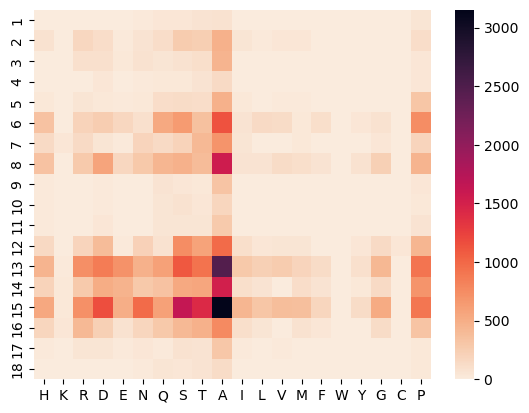

In [139]:
sns.heatmap(mtx.T, cmap="rocket_r")
plt.savefig('results/changes_heatmap_predictions_ALL_mut_most_active_v03.png', dpi=1200)

### AA frequency change in least active peptides

In [86]:
least_act["difference_in_seq"] = [diff_func(x) for x in least_act["Sequence"]]

diff = least_act["difference_in_seq"].str.split("", n= -1, expand = True)

least_act =least_act.merge(diff, left_index=True, right_index=True)

least_act

,ID,Sequence,MIC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
400,2mut_400,RGYRLGYCRRRFCVCVGR,0.0,2.98,41.66,--Y--G------------,,-,-,Y,-,-,G,-,-,-,-,-,-,-,-,-,-,-,-,
741,2mut_741,RGGRLCYCRLFFCVCVGR,0.0,3.65,43.86,---------LF-------,,-,-,-,-,-,-,-,-,-,L,F,-,-,-,-,-,-,-,
789,2mut_789,RGGRLCVCRRRFCVCLGR,0.0,2.70,34.68,------V--------L--,,-,-,-,-,-,-,V,-,-,-,-,-,-,-,-,L,-,-,
3078,2mut_3078,LGGRLCVCRRRFCVCVGR,0.0,2.86,30.31,L-----V-----------,,L,-,-,-,-,-,V,-,-,-,-,-,-,-,-,-,-,-,
4087,2mut_4087,RGGRLCVCWRRFCVCVGR,0.0,3.27,36.04,------V-W---------,,-,-,-,-,-,-,V,-,W,-,-,-,-,-,-,-,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651804,PG1_3mut_5651804,RGGRLCYWRWRFCVCVGL,0.0,3.09,31.17,-------W-W-------L,,-,-,-,-,-,-,-,W,-,W,-,-,-,-,-,-,-,L,
5652367,PG1_3mut_5652367,RGGVLCYCFRWFCVCVGR,0.0,3.81,41.48,---V----F-W-------,,-,-,-,V,-,-,-,-,F,-,W,-,-,-,-,-,-,-,
5652372,PG1_3mut_5652372,YGGRLCFCGRRFCVCVGR,0.0,3.03,34.48,Y-----F-G---------,,Y,-,-,-,-,-,F,-,G,-,-,-,-,-,-,-,-,-,
5652377,PG1_3mut_5652377,RGGRYCYCRCRFCVCIGR,0.0,3.06,42.00,----Y----C-----I--,,-,-,-,-,Y,-,-,-,-,C,-,-,-,-,-,I,-,-,


In [87]:
# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = least_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

mtx

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
H,124,33,83,67,133,17,2,6,105,143,116,81,0,71,1,93,285,40
K,194,194,459,238,644,190,52,27,425,491,583,362,6,202,15,95,815,133
R,0,42,62,0,89,11,7,4,0,0,0,49,2,33,6,55,306,0
D,75,12,37,46,12,20,8,1,63,40,48,12,0,16,0,11,37,99
E,163,68,249,80,162,26,137,7,238,110,96,19,0,16,0,39,145,239
N,98,17,21,60,54,36,2,21,153,40,32,64,4,49,2,38,109,46
Q,150,31,39,38,17,11,5,4,47,64,23,7,1,24,0,22,217,27
S,72,23,37,45,45,30,19,10,76,70,96,18,1,33,1,35,31,43
T,111,29,31,57,58,40,18,9,243,46,70,14,0,18,0,23,38,68
A,66,24,18,100,20,49,122,2,216,200,80,1,0,3,0,13,12,183


<Axes: >

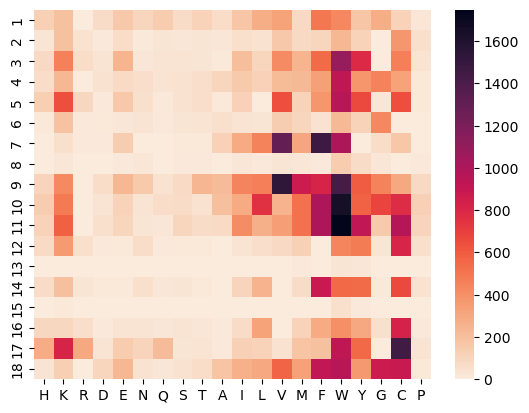

In [88]:
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_ALL_mut_least_active_3.png' , dpi=1200)

# Part 2 - Validation on testes peptides

In [89]:
# This function wil convert the undefined MIC values to 100.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        mic_value = float(mic_value.replace('>', ''))
        v = 100
        return v
    else:
        return float(mic_value)

In [90]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_validation_set_v01.csv', index_col=0)
meta_data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.00,-0.99,0.05
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.00,-1.22,-0.69
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.00,-1.31,-0.48
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.00,-0.69,-2.75
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.00,-0.25,0.45
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.00,-0.70,-1.78
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.00,-0.42,1.34
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.00,-0.84,-3.68
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.00,-0.70,-1.41
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.00,-0.34,-4.14


In [91]:
######################## Load the embedding ######################
dir_path = 'data/embedding/esm2_15B_PG1_validation/'
embeddings = {}
for file in os.listdir(dir_path):
        file_path = str(dir_path) + file 
        label = file.split('.pt')[0]
        embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID2', right_index=True)
data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.00,-0.99,0.05,0.109975,-0.134590,-0.111443,0.218644,-0.237748,0.131493,-0.119502,0.234007,-0.042554,0.338132,-0.181911,-0.070123,0.285914,0.132456,0.145206,-0.119641,0.016052,-0.160409,0.175323,0.006981,0.031700,0.035921,-0.388611,0.106619,-0.263324,0.010144,0.089600,-0.232413,0.044148,0.205849,-0.088589,-0.051135,-0.249299,-0.100425,-0.034155,-0.042539,...,-0.287571,-0.199986,0.265588,-0.087591,-0.035537,0.052414,-0.032724,0.074804,0.253470,0.188196,0.000840,-0.048806,0.006446,0.150435,0.038589,0.085381,-0.230726,0.268536,-0.116890,-0.014526,-0.264989,-0.072022,-0.083098,-0.169087,0.285792,0.045038,0.190472,-0.006061,0.086329,-0.000662,0.091908,0.035746,-0.148846,-0.118648,-0.209491,-0.021450,-0.027162,-0.213849,-0.050013,0.006487,-0.136047,-0.087660,0.107472,-0.270478,0.122341,-0.089307,0.137297,0.075365,-0.198461,-0.035045
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.00,-1.22,-0.69,0.129701,-0.184889,-0.115536,0.161651,-0.224050,0.112427,-0.157890,0.269912,-0.049523,0.307800,-0.149578,-0.081749,0.265789,0.177847,0.169391,-0.094384,0.128813,-0.176698,0.105074,0.014042,0.026007,0.069966,-0.333289,0.142775,-0.248938,-0.029828,0.020388,-0.144963,0.050747,0.161994,-0.136832,-0.064507,-0.254568,-0.029669,-0.057159,0.031107,...,-0.252198,-0.117499,0.283669,-0.081878,-0.082878,0.056859,-0.002050,0.037367,0.262278,0.109654,0.026107,0.013662,0.029625,0.179096,0.087634,0.068997,-0.194529,0.256631,-0.086368,0.013377,-0.315640,-0.012413,-0.098380,-0.130370,0.274497,0.049318,0.221853,-0.059104,0.077843,-0.038710,0.128514,0.042598,-0.170303,-0.052412,-0.178424,-0.050331,-0.044874,-0.277650,0.018790,-0.008888,-0.106790,-0.129787,0.076798,-0.208119,0.098149,-0.133004,0.089372,0.093026,-0.170869,-0.013929
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.00,-1.31,-0.48,0.099468,-0.114953,-0.117187,0.183187,-0.209792,0.091260,-0.130392,0.256235,-0.053187,0.229403,-0.153716,-0.110329,0.224579,0.217258,0.185253,-0.137833,0.123428,-0.071266,0.113991,-0.005573,0.083241,0.095849,-0.291120,0.084410,-0.293609,-0.046842,0.064312,-0.096830,0.032436,0.084759,-0.103322,-0.039152,-0.284039,-0.067096,-0.115826,0.051603,...,-0.265148,-0.125474,0.232081,-0.136144,-0.026184,0.075733,0.041864,0.058491,0.310277,0.156786,-0.067325,0.029883,0.027132,0.108766,0.068593,-0.053529,-0.139792,0.200807,-0.150195,0.036576,-0.200391,-0.061608,-0.052911,-0.173216,0.241643,0.071768,0.181315,-0.034740,0.006019,-0.071225,0.139590,0.150875,-0.073768,-0.083165,-0.124568,-0.063161,-0.023962,-0.257893,0.000161,0.006935,-0.195330,-0.116773,0.137988,-0.164647,0.119364,-0.178338,0.031593,0.029154,-0.215111,-0.017543
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.00,-0.69,-2.75,0.156776,-0.105166,-0.063266,0.204592,-0.202521,0.076685,-0.140390,0.251750,-0.082083,0.299491,-0.138542,-0.093754,0.238516,0.210513,0.224224,-0.099772,0.084619,-0.138276,0.065005,0.034831,0.028210,0.085703,-0.210246,0.129641,-0.316469,-0.079329,0.070912,-0.132105,-0.009244,0.151050,-0.079498,-0.048807,-0.207856,-0.036181,-0.060802,0.062600,...,-0.269408,-0.143549,0.283143,-0.004776,-0.062685,0.133809,0.033932,0.047367,0.329623,0.135072,-0.037661,0.074512,0.027695,0.104189,0.026622,0.066428,-0.113747,0.26

In [92]:
features = data.iloc[:,meta_data.shape[1]:]
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.109975,-0.134590,-0.111443,0.218644,-0.237748,0.131493,-0.119502,0.234007,-0.042554,0.338132,-0.181911,-0.070123,0.285914,0.132456,0.145206,-0.119641,0.016052,-0.160409,0.175323,0.006981,0.031700,0.035921,-0.388611,0.106619,-0.263324,0.010144,0.089600,-0.232413,0.044148,0.205849,-0.088589,-0.051135,-0.249299,-0.100425,-0.034155,-0.042539,0.145001,-0.053556,0.325825,0.009630,0.188548,-0.276242,0.057267,0.159372,-0.074977,0.383486,-0.059249,0.067180,-0.192458,-0.160447,...,-0.287571,-0.199986,0.265588,-0.087591,-0.035537,0.052414,-0.032724,0.074804,0.253470,0.188196,0.000840,-0.048806,0.006446,0.150435,0.038589,0.085381,-0.230726,0.268536,-0.116890,-0.014526,-0.264989,-0.072022,-0.083098,-0.169087,0.285792,0.045038,0.190472,-0.006061,0.086329,-0.000662,0.091908,0.035746,-0.148846,-0.118648,-0.209491,-0.021450,-0.027162,-0.213849,-0.050013,0.006487,-0.136047,-0.087660,0.107472,-0.270478,0.122341,-0.089307,0.137297,0.075365,-0.198461,-0.035045
1,0.129701,-0.184889,-0.115536,0.161651,-0.224050,0.112427,-0.157890,0.269912,-0.049523,0.307800,-0.149578,-0.081749,0.265789,0.177847,0.169391,-0.094384,0.128813,-0.176698,0.105074,0.014042,0.026007,0.069966,-0.333289,0.142775,-0.248938,-0.029828,0.020388,-0.144963,0.050747,0.161994,-0.136832,-0.064507,-0.254568,-0.029669,-0.057159,0.031107,0.171488,-0.025439,0.370129,-0.041123,0.135727,-0.279007,0.066811,0.166149,-0.087821,0.364228,-0.020949,0.117404,-0.246447,-0.102719,...,-0.252198,-0.117499,0.283669,-0.081878,-0.082878,0.056859,-0.002050,0.037367,0.262278,0.109654,0.026107,0.013662,0.029625,0.179096,0.087634,0.068997,-0.194529,0.256631,-0.086368,0.013377,-0.315640,-0.012413,-0.098380,-0.130370,0.274497,0.049318,0.221853,-0.059104,0.077843,-0.038710,0.128514,0.042598,-0.170303,-0.052412,-0.178424,-0.050331,-0.044874,-0.277650,0.018790,-0.008888,-0.106790,-0.129787,0.076798,-0.208119,0.098149,-0.133004,0.089372,0.093026,-0.170869,-0.013929
2,0.099468,-0.114953,-0.117187,0.183187,-0.209792,0.091260,-0.130392,0.256235,-0.053187,0.229403,-0.153716,-0.110329,0.224579,0.217258,0.185253,-0.137833,0.123428,-0.071266,0.113991,-0.005573,0.083241,0.095849,-0.291120,0.084410,-0.293609,-0.046842,0.064312,-0.096830,0.032436,0.084759,-0.103322,-0.039152,-0.284039,-0.067096,-0.115826,0.051603,0.165042,-0.094658,0.376194,-0.128548,0.181254,-0.249639,0.065785,0.160171,-0.091013,0.350580,0.005549,0.078152,-0.205696,-0.069624,...,-0.265148,-0.125474,0.232081,-0.136144,-0.026184,0.075733,0.041864,0.058491,0.310277,0.156786,-0.067325,0.029883,0.027132,0.108766,0.068593,-0.053529,-0.139792,0.200807,-0.150195,0.036576,-0.200391,-0.061608,-0.052911,-0.173216,0.241643,0.071768,0.181315,-0.034740,0.006019,-0.071225,0.139590,0.150875,-0.073768,-0.083165,-0.124568,-0.063161,-0.023962,-0.257893,0.000161,0.006935,-0.195330,-0.116773,0.137988,-0.164647,0.119364,-0.178338,0.031593,0.029154,-0.215111,-0.017543
3,0.156776,-0.105166,-0.063266,0.204592,-0.202521,0.076685,-0.140390,0.251750,-0.082083,0.299491,-0.138542,-0.093754,0.238516,0.210513,0.224224,-0.099772,0.084619,-0.138276,0.065005,0.034831,0.028210,0.085703,-0.210246,0.129641,-0.316469,-0.079329,0.070912,-0.132105,-0.009244,0.151050,-0.079498,-0.048807,-0.207856,-0.036181,-0.060802,0.062600,0.129042,-0.139074,0.310381,-0.097736,0.152451,-0.305469,0.069221,0.137120,-0.135764,0.433612,-0.017008,0.039403,-0.203412,-0.054635,...,-0.269408,-0.143549,0.283143,-0.004776,-0.062685,0.133809,0.033932,0.047367,0.329623,0.135072,-0.037661,0.074512,0.027695,0.104189,0.026622,0.066428,-0.113747,0.263858,-0.121201,0.010072,-0.256017,-0.060592,-0.097629,-0.164075,0.268416,-0.001478,0.174

# Predictions

## Hemolysis

In [97]:
# load PCA weights and models for hemolysis prediction
pca_hemo = joblib.load('models/pca25_weights_v03_hemo.pkl') # hemo
model_hemo = joblib.load('models/model_v03_Lasso25_esm2_15B_hemolysis_regression.pkl')
X = pca_hemo.transform(features)


In [100]:
res_hemo = data.iloc[:,:meta_data.shape[1]]

# calculates the the hemolysis score
pred = model_hemo.predict(X)
res_hemo['hemolysis_pred_v02']= pred

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred_v02 <= 2').shape[0]} peptides with predicted hemolysis% <= 2%")

29 peptides with predicted hemolysis% <= 2%


In [101]:
# Model evaluation on test data
true_hemo = res_hemo['%hemo']
pred_hemo = res_hemo['hemolysis_pred_v02']

r2 = metrics.r2_score(true_hemo, pred_hemo)
mae = metrics.mean_absolute_error(true_hemo, pred_hemo)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(true_hemo, pred_hemo)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -1.4008114910962006, MAE: 3.0264224124104526
Spearman correlation coefficient: 0.19
P-value: 0.26


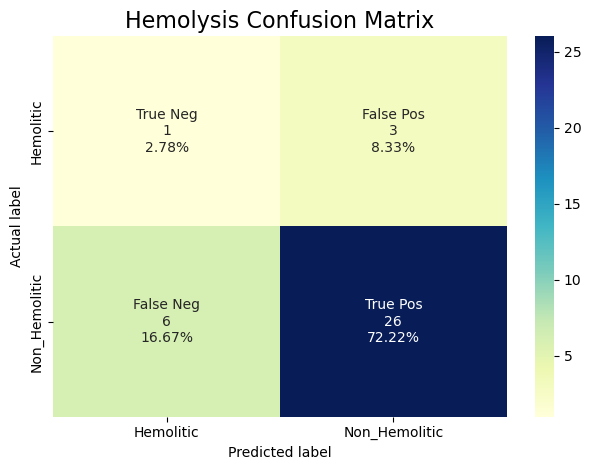

In [102]:
#confusion_matrix, 
true = [1 if x <=2 else 0 for x in true_hemo]
pred = [1 if x<=2 else 0 for x in pred_hemo]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Hemolitic', 'Non_Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolysis Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [103]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.75
Recall: 0.81
Precision: 0.90
F1 Score: 0.85


In [104]:
df = pd.read_csv('results/model_v01_performance.csv')
df_dict={'Version': 'V02', 'Feature': 'Hemolysis', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.0000,0.944444,0.971429
1,V01,Selectivity,0.214286,1.0000,0.214286,0.352941
2,V01,Activity,0.250000,1.0000,0.250000,0.400000
0,V02,Hemolysis,0.750000,0.8125,0.896552,0.852459


## Selectivity

In [105]:
cutoff_sel = 1

In [106]:
# load PCA weights and models for selectivity prediction
pca_sel = joblib.load('models/pca15_weights_v03_sel.pkl') # sel
model_sel = joblib.load('models/model_v03_SVR15_esm2_15B_selectivity_regression.pkl')
X = pca_sel.transform(features)

In [108]:
res_sel = data.iloc[:,:meta_data.shape[1]]
# calculates the selectivity score
pred = model_sel.predict(X)
res_sel['selectivity_pred_v02']= pred

#number of peptides with hemolysis score < 1
print(f"{res_sel.query('selectivity_pred_v02 < 1').shape[0]} peptides with predicted hemolysis% < 0.5")

29 peptides with predicted hemolysis% < 0.5


In [109]:
res = res_sel[~res_sel['L10Select'].isna()]
# Model evaluation on test data
true_sel = res['L10Select']
pred_sel = res['selectivity_pred_v02']

r2 = metrics.r2_score(true_sel, pred_sel)
mae = metrics.mean_absolute_error(true_sel, pred_sel)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(true_sel, pred_sel)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -0.0890665773088215, MAE: 0.4261484315122951
Spearman correlation coefficient: 0.32
P-value: 0.10


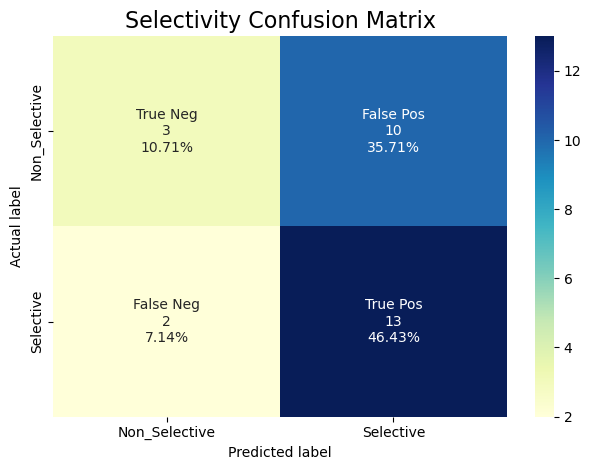

In [110]:
#confusion_matrix, 
true = [1 if x<=cutoff_sel else 0 for x in true_sel]
pred = [1 if x<=cutoff_sel else 0 for x in pred_sel]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Selective', 'Selective']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Selectivity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [111]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.57
Recall: 0.87
Precision: 0.57
F1 Score: 0.68


In [112]:
df_dict={'Version': 'V02', 'Feature': 'Selectivity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.000000,0.944444,0.971429
1,V01,Selectivity,0.214286,1.000000,0.214286,0.352941
2,V01,Activity,0.250000,1.000000,0.250000,0.400000
0,V02,Hemolysis,0.750000,0.812500,0.896552,0.852459
0,V02,Selectivity,0.571429,0.866667,0.565217,0.684211


## Activity

In [113]:
cutoff=90

In [114]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    

In [115]:
# load PCA weights and models for activity prediction
pca_mic = joblib.load('models/pca30_weights_v03_mic.pkl') # mic
model_mic = joblib.load('models/model_v03_GNB30_esm2_15B_activity_classification.pkl')
X = pca_mic.transform(features)

In [116]:
res_mic = data.iloc[:,:meta_data.shape[1]]

# calculates the probability of being active
prob= model_mic.predict_proba(X)
res_mic['MIC_pred_v02']= [(x[1]*100).round(2) for x in prob]

#number of peptides with hemolysis score < 1
res_mic.query('MIC_pred_v02 > 90')

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC_pred_v02
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.0,-0.99,0.05,98.23
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.25,0.45,96.10
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.42,1.34,98.83
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.84,-3.68,98.95
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.34,-4.14,99.25
11,bsPG-1.12,RGGRLQYCRRRFCARVGR,-----Q-------AR---,-0.27,6.742145,PG1_3mut_720432,<-0.25,16,0.141326,0.354341,2.261209,100.0,-0.35,-0.04,98.52
13,bsPG-1.14,RGGRLCTARRRFCVHVGR,------TA------H---,-0.22,5.835569,PG1_3mut_1926344,-0.25-0,16,0.638402,1.009214,10.214425,100.0,-0.20,3.52,98.47
15,bsPG-1.16,RGGRLQYCRRRFDTCVGR,-----Q------DT----,-0.14,4.742406,PG1_3mut_969074,-0.25-0,>64,0.034113,NaN,NaN,100.0,-1.03,-3.77,98.19
16,bsPG-1.17,RGGRLCTCRRRFCASVGR,------T------AS---,-0.14,5.653751,PG1_3mut_624778,-0.25-0,32,0.487329,1.192973,15.594542,100.0,-0.07,2.79,99.86
17,bsPG-1.18,RGGRLRYCRRRFRVSVGR,-----R------R-S---,-0.13,7.833044,PG1_3mut_1114717,-0.25-0,16,1.525341,1.387487,24.405458,100.0,-0.40,1.30,94.08


In [117]:
# Load meta data
res_mic['Active'] = [convert_mic(x) for x in res_mic['MIC MH']]
res_mic

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC_pred_v02,Active
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.00,-0.99,0.05,98.23,0
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.00,-1.22,-0.69,50.74,1
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.00,-1.31,-0.48,70.77,0
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.00,-0.69,-2.75,86.33,0
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.00,-0.25,0.45,96.10,1
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.00,-0.70,-1.78,80.02,0
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.00,-0.42,1.34,98.83,1
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.00,-0.84,-3.68,98.95,0
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.00,-0.70,-1.41,85.32,0
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.00,-0.34,-4.14,99.25,0


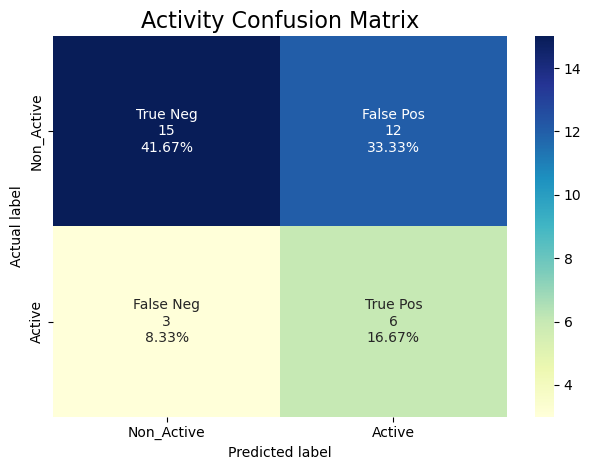

In [118]:
#confusion_matrix, 
true = res_mic['Active']
pred = [1 if x>cutoff else 0 for x in res_mic['MIC_pred_v02']]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

labelsx = ['Non_Active', 'Active']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Activity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [119]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.58
Recall: 0.67
Precision: 0.33
F1 Score: 0.44


# Overall Performance

In [120]:
df_dict={'Version': 'V02', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.000000,0.944444,0.971429
1,V01,Selectivity,0.214286,1.000000,0.214286,0.352941
2,V01,Activity,0.250000,1.000000,0.250000,0.400000
0,V02,Hemolysis,0.750000,0.812500,0.896552,0.852459
0,V02,Selectivity,0.571429,0.866667,0.565217,0.684211
0,V02,Activity,0.583333,0.666667,0.333333,0.444444


In [ ]:
#df.to_csv('results/model_v01-2_performance.csv', index=False)
# df = pd.read_csv('results/model_v01-2_performance.csv')
# df

In [121]:
# id_vars: Columns that should remain unaltered.
# value_vars: Columns that you want to melt (i.e., unpivot). These columns will be transformed from wide format to long format.
# var_name: Name of the new column that will store the melted columns' names (default is 'variable').
# value_name: Name of the new column that will store the values (default is 'value').

df_melted = pd.melt(df, 
        id_vars=['Version', 'Feature'],
        value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score'],
        var_name='Metric',
        value_name='Score')

df_melted= df_melted.sort_values(by=['Version', 'Feature', 'Metric']).reset_index(drop=True)
df_melted

,Version,Feature,Metric,Score
0,V01,Activity,Accuracy,0.250000
1,V01,Activity,F1 Score,0.400000
2,V01,Activity,Precision,0.250000
3,V01,Activity,Recall,1.000000
4,V01,Hemolysis,Accuracy,0.944444
5,V01,Hemolysis,F1 Score,0.971429
6,V01,Hemolysis,Precision,0.944444
7,V01,Hemolysis,Recall,1.000000
8,V01,Selectivity,Accuracy,0.214286
9,V01,Selectivity,F1 Score,0.352941


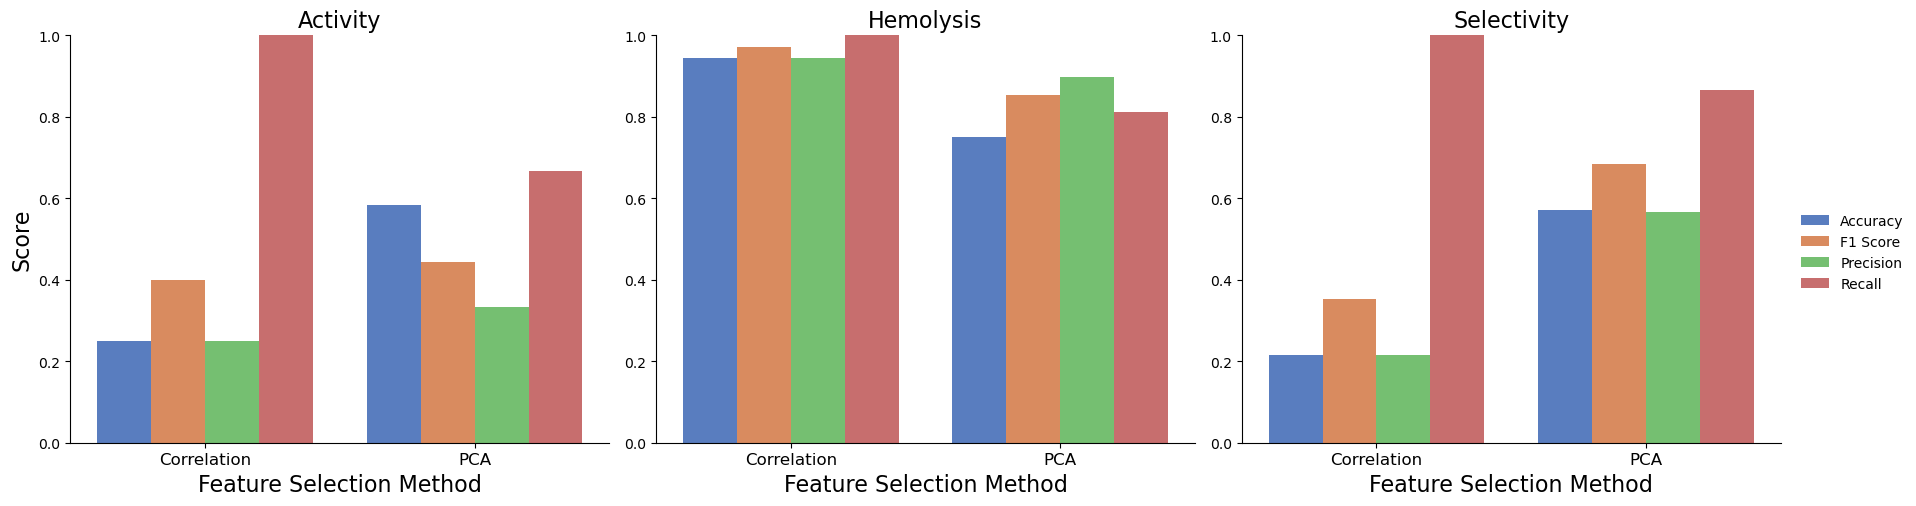

In [122]:
g = sns.FacetGrid(df_melted, col="Feature", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Version", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Feature Selection Method", "Score", size=16)


axes = g.axes.flatten()
axes[0].set_title("Activity", size=16)
axes[1].set_title("Hemolysis", size=16)
axes[2].set_title("Selectivity", size=16)

tick_labels = ['Correlation', 'PCA']
for ax in axes: 
    ax.set_xticks(range(len(tick_labels)))  # Set x-tick positions
    ax.set_xticklabels(tick_labels, size=12) 


g.add_legend()
plt.savefig('results/model_v01-3_performance.png', dpi=1200)

## Merging results

In [123]:
cols =['ID2', 'Sequence', 'RGGRLCYCRRRFCVCVGR', 'Select', 'Charge', 'ID',
       'group', 'MIC MH', '%hemo', 'L10Select', 'L10select_adj',
       'MIC_8_pred_v01', 'selectivity_pred_v01', 'hemolysis_pred_v01',
       'MIC_pred_v02', 'selectivity_pred_v02', 'hemolysis_pred_v02',
       'Active', 'Non_Hemolitic', 'Selective']

In [124]:
results = res_mic.merge(res_sel[['ID', 'selectivity_pred_v02']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred_v02']], how='inner', left_on='ID', right_on='ID')
results.rename(columns={'MBC_8_prob': 'MIC_8_pred_v01', 'selectivity_pred': 'selectivity_pred_v01',
                        'hemolysis_pred': 'hemolysis_pred_v01'}, inplace=True)

results['Non_Hemolitic'] = [1 if x <=2 else 0 for x in results['%hemo']]
results['MIC MH'].replace('>64', 100, inplace=True)
results['MIC MH'] = results['MIC MH'].astype('float64')
results['L10select_adj'] = np.log10((results['%hemo']+0.2) * results['MIC MH']) -0.2
results['Selective'] = [1 if x <=1 else 0 for x in results['L10select_adj']]
results = results[cols]
results

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,L10select_adj,MIC_8_pred_v01,selectivity_pred_v01,hemolysis_pred_v01,MIC_pred_v02,selectivity_pred_v02,hemolysis_pred_v02,Active,Non_Hemolitic,Selective
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16.0,0.428850,0.836425,0.802667,100.00,-0.99,0.05,98.23,0.347237,-1.893507,0,1,1
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4.0,0.341131,0.134981,0.135362,100.00,-1.22,-0.69,50.74,0.411218,-4.661005,1,1,1
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,100.0,-0.165692,NaN,0.335395,100.00,-1.31,-0.48,70.77,0.513092,-4.901098,0,1,1
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64.0,0.165692,1.025482,1.169295,100.00,-0.69,-2.75,86.33,0.678893,-1.040323,0,1,0
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8.0,0.721248,0.761174,0.667466,100.00,-0.25,0.45,96.10,0.647349,-1.423445,1,1,1
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16.0,0.735867,1.070920,0.975334,100.00,-0.70,-1.78,80.02,0.467890,-2.650885,0,1,1
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2.0,0.906433,0.258366,0.144955,100.00,-0.42,1.34,98.83,0.540695,-1.180048,1,1,1
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16.0,0.043860,-0.153815,0.391260,100.00,-0.84,-3.68,98.95,0.514188,-0.492886,0,1,1
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32.0,0.116959,0.573184,0.806153,100.00,-0.70,-1.41,85.32,0.262534,-9.513510,0,1,1
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64.0,0.092593,0.772756,1.072443,100.00,-0.34,-4.14,99.25,0.467680,-1.762207,0,1,0


In [128]:
#results.to_excel('results/predictions_MIC_SEL_HEMO_models_PG1_validation_set_v03.xlsx')

In [125]:
results.query('Active == 1 & Non_Hemolitic == 1 & Selective == 1')

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,L10select_adj,MIC_8_pred_v01,selectivity_pred_v01,hemolysis_pred_v01,MIC_pred_v02,selectivity_pred_v02,hemolysis_pred_v02,Active,Non_Hemolitic,Selective
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4.0,0.341131,0.134981,0.135362,100.0,-1.22,-0.69,50.74,0.411218,-4.661005,1,1,1
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8.0,0.721248,0.761174,0.667466,100.0,-0.25,0.45,96.10,0.647349,-1.423445,1,1,1
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2.0,0.906433,0.258366,0.144955,100.0,-0.42,1.34,98.83,0.540695,-1.180048,1,1,1
20,bsPG-1.21,RGGRLCYRRRRTAVCVGR,-------R---TA-----,-0.10,6.742145,PG1_3mut_789807,CP,8.0,0.404483,0.509991,0.484474,100.0,-0.22,4.96,91.90,0.495483,-3.847427,1,1,1
26,bsPG-1.27,RGGRDIYCRRRFCVTVGR,----DI--------T---,0.10,4.742406,PG1_3mut_840730,0-0.5,8.0,0.662768,0.724452,0.638984,100.0,0.12,0.16,4.86,1.130469,2.597206,1,1,1
29,bsPG-1.30,RGGRLAYCRRRFCVAVAR,-----A--------A-A-,0.36,5.742155,PG1_3mut_439660,0-0.5,2.0,1.076998,0.333245,0.207220,100.0,0.66,1.99,96.36,0.563254,-0.593428,1,1,1


In [142]:
results.query('MIC_pred_v02 > 90 & selectivity_pred_v02 < 1 & hemolysis_pred_v02 <= 2').shape

(14, 20)

In [127]:
#results.to_excel('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_validation_set_v01-03.xlsx')